In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report


Reading the accompanying .names file, I have learned that there are ten features for each cell nucleus, and these have ten features have 3 results each - the mean, standard error, and "worst".

In [35]:
# 1. Data Collection
columns = ['ID_Number','Diagnosis','Radius','Texture','Perimeter','Area','Smoothness','Compactness','Concavity','Concave_points','Symmetry','Fractal_Dimension','Radius_SE','Texture_SE','Perimeter_SE','Area_SE','Smoothness_SE','Compactness_SE','Concavity_SE','Concave_points_SE','Symmetry_SE','Fractal_Dimension_SE','Radius_Worst','Texture_Worst','Perimeter_Worst','Area_Worst','Smoothness_Worst','Compactness_Worst','Concavity_Worst','Concave_points_Worst','Symmetry_Worst','Fractal_Dimension_Worst']
df = pd.read_csv('Data/wdbc.data', names=columns)
df['Diagnosis'] = df['Diagnosis'].map({'B':0,'M':1})
print(df.head())

   ID_Number  Diagnosis  Radius  Texture  Perimeter    Area  Smoothness  \
0     842302          1   17.99    10.38     122.80  1001.0     0.11840   
1     842517          1   20.57    17.77     132.90  1326.0     0.08474   
2   84300903          1   19.69    21.25     130.00  1203.0     0.10960   
3   84348301          1   11.42    20.38      77.58   386.1     0.14250   
4   84358402          1   20.29    14.34     135.10  1297.0     0.10030   

   Compactness  Concavity  Concave_points  ...  Radius_Worst  Texture_Worst  \
0      0.27760     0.3001         0.14710  ...         25.38          17.33   
1      0.07864     0.0869         0.07017  ...         24.99          23.41   
2      0.15990     0.1974         0.12790  ...         23.57          25.53   
3      0.28390     0.2414         0.10520  ...         14.91          26.50   
4      0.13280     0.1980         0.10430  ...         22.54          16.67   

   Perimeter_Worst  Area_Worst  Smoothness_Worst  Compactness_Worst  \
0  

In [20]:
# 2. Exploratory Data Analysis
df.info()
df.describe()
df.isnull().sum()

# All my features are numerical, so I don't need to encode them, but I will scale them.
# There are no missing values in the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID_Number                569 non-null    int64  
 1   Diagnosis                569 non-null    int64  
 2   Radius                   569 non-null    float64
 3   Texture                  569 non-null    float64
 4   Perimeter                569 non-null    float64
 5   Area                     569 non-null    float64
 6   Smoothness               569 non-null    float64
 7   Compactness              569 non-null    float64
 8   Concavity                569 non-null    float64
 9   Concave_points           569 non-null    float64
 10  Symmetry                 569 non-null    float64
 11  Fractal_Dimension        569 non-null    float64
 12  Radius_SE                569 non-null    float64
 13  Texture_SE               569 non-null    float64
 14  Perimeter_SE             5

ID_Number                  0
Diagnosis                  0
Radius                     0
Texture                    0
Perimeter                  0
Area                       0
Smoothness                 0
Compactness                0
Concavity                  0
Concave_points             0
Symmetry                   0
Fractal_Dimension          0
Radius_SE                  0
Texture_SE                 0
Perimeter_SE               0
Area_SE                    0
Smoothness_SE              0
Compactness_SE             0
Concavity_SE               0
Concave_points_SE          0
Symmetry_SE                0
Fractal_Dimension_SE       0
Radius_Worst               0
Texture_Worst              0
Perimeter_Worst            0
Area_Worst                 0
Smoothness_Worst           0
Compactness_Worst          0
Concavity_Worst            0
Concave_points_Worst       0
Symmetry_Worst             0
Fractal_Dimension_Worst    0
dtype: int64

In [36]:
# 2. Data Cleaning

# I need to remove the ID_Number column, as it is not useful for the model.
df.drop('ID_Number', axis=1, inplace=True)

# check for outliers in the data set.
from scipy.stats import zscore
z_scores = zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
num_outliers = (~filtered_entries).sum()
print(f"Number of outliers: {num_outliers}")
df_filtered = df[filtered_entries]
# I don't know if these outliers are crucial to detecting cancer, so I will keep them in for now, and run tests later.

Number of outliers: 74


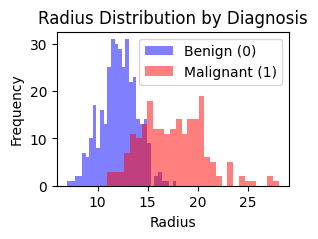

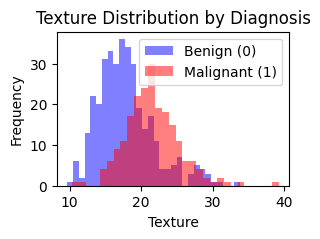

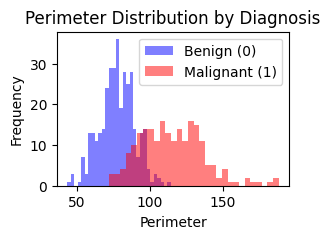

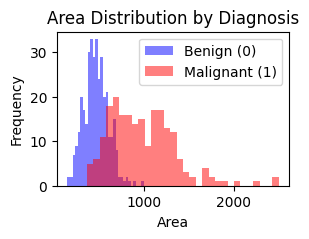

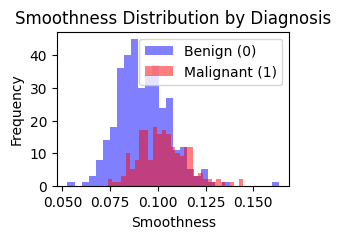

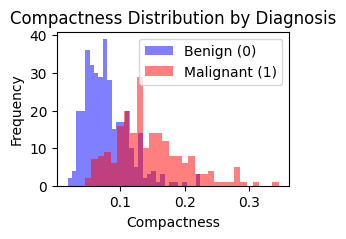

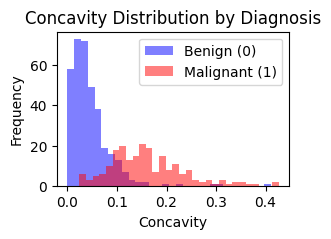

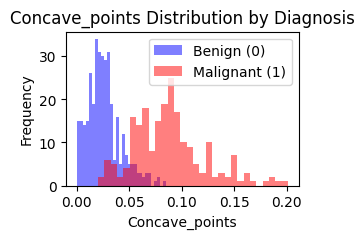

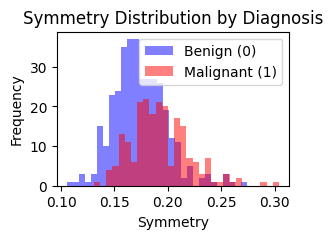

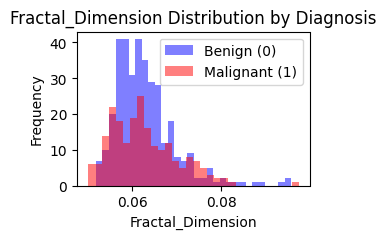

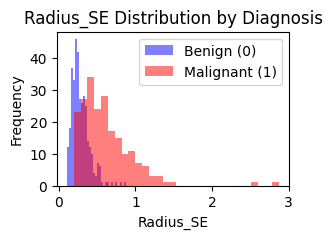

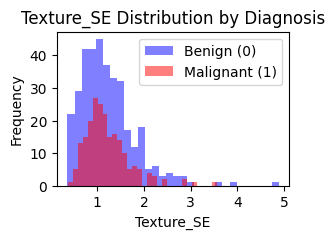

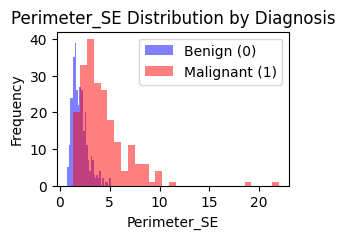

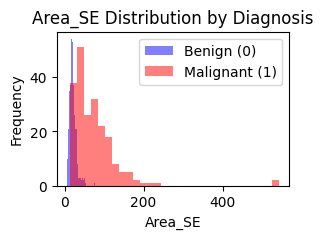

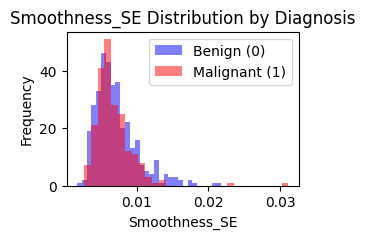

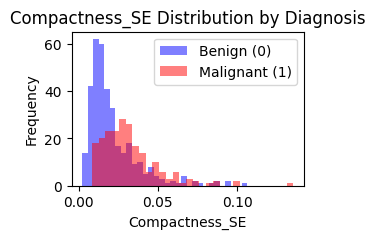

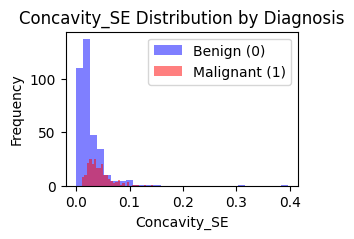

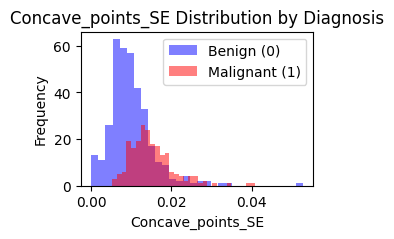

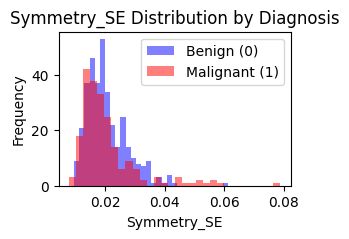

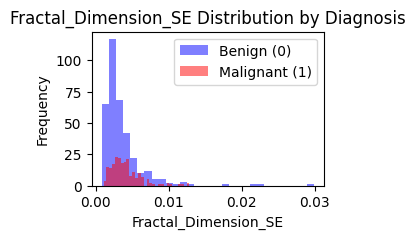

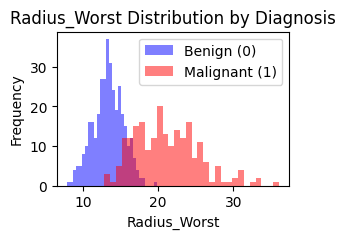

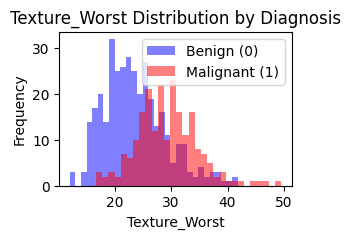

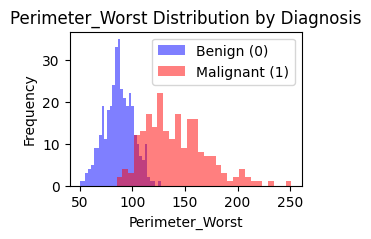

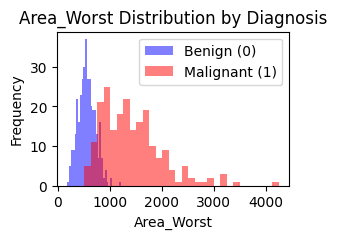

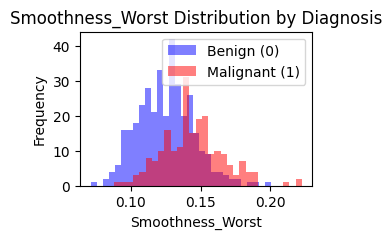

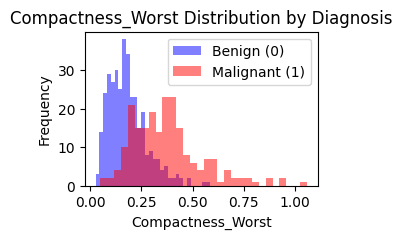

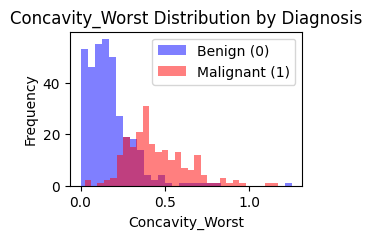

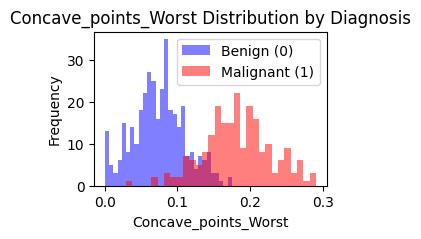

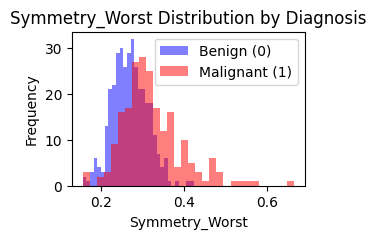

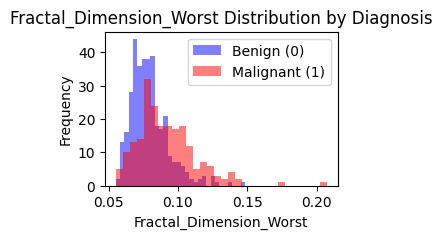

In [31]:
# 3 EDA - visualizing the data

# Histogram of each feature, grouped by diagnosis

df_malignant = df[df['Diagnosis'] == 1]
df_benign = df[df['Diagnosis'] == 0]

for column in df.columns:
    if column != 'Diagnosis' and column != 'ID_Number':
        plt.figure(figsize=(3, 2))
        plt.hist(df_benign[column], bins=30, color='b', alpha=0.5, label='Benign (0)')
        plt.hist(df_malignant[column], bins=30, color='r', alpha=0.5, label='Malignant (1)')
        plt.legend(loc='upper right')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'{column} Distribution by Diagnosis')
        plt.show()


Looking at these visualisations of each feature in the data, some of the graphs have quite a clear divide between the Benign and Malignant diagnoses, with a small overlap, such as concave points, radius worst, perimeter worst, area worst, concave points worst.
There are others which have do not have a clear divide, and so perhaps will not be as important of a feature for the diagnosis.

In [44]:
# Preliminary Model Training - Testing and scoring a selection of classifiers before feature engineering so I can compare results after.

y = df['Diagnosis']
X = df.drop('Diagnosis', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scores = {}

# List of classifiers
classifiers = [
    (RandomForestClassifier(), "RandomForestClassifier score"),
    (RandomForestRegressor(), "RandomForestRegressor score"),
    (SVC(), "SVC score"),
    (KNeighborsClassifier(), "KNeighborsClassifier score"),
    (GradientBoostingClassifier(), "GradientBoostingClassifier score"),
    (MLPClassifier(), "MLPClassifier score"),
    (LogisticRegression(max_iter=1000), "LogisticRegression score"),
    (AdaBoostClassifier(algorithm="SAMME"), "AdaBoostClassifier score"),
    (ExtraTreesClassifier(), "ExtraTreesClassifier score"),
    (BaggingClassifier(), "BaggingClassifier score")
]

# Train and score each classifier
for clf, clf_name in classifiers:
    clf.fit(X_train, y_train)
    scores[clf_name] = clf.score(X_test, y_test)

# Print scores in descending order
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_scores:
    print(f'{key}: {value}')

/Users/user/Dropbox/Python/Wheel/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/user/Dropbox/Python/Wheel/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ExtraTreesClassifier score: 0.9736842105263158
RandomForestClassifier score: 0.9649122807017544
AdaBoostClassifier score: 0.9649122807017544
KNeighborsClassifier score: 0.956140350877193
GradientBoostingClassifier score: 0.956140350877193
LogisticRegression score: 0.956140350877193
BaggingClassifier score: 0.956140350877193
SVC score: 0.9473684210526315
MLPClassifier score: 0.9473684210526315
RandomForestRegressor score: 0.8545146413363904


ExtraTreesClassifier score before removing features: 0.9666045645086166


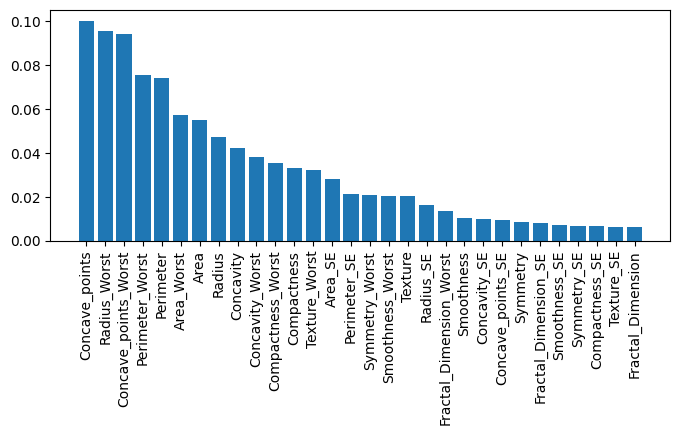

In [85]:
# 4. Feature Engineering

y = df['Diagnosis']
X = df.drop('Diagnosis', axis=1)

# As I learned earlier, all my features are numerical, so I don't need to encode them, but I will scale them.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
etc1 = ExtraTreesClassifier()
etc1.fit(X_train, y_train)
#print(f"ExtraTreesClassifier score before removing features: {etc1.score(X_test, y_test)}")

etc_score = cross_val_score(etc1, X_scaled, y, cv=5)
print(f"ExtraTreesClassifier score before removing features: {etc_score.mean()}")

importances = etc1.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 3))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

Random Forest Classifier - Max score: 0.9649122807017543 with 20 features
SVC - Max score: 0.9753759398496239 with 19 features
KNeighbors Classifier - Max score: 0.9718671679197994 with 25 features
Gradient Boosting Classifier - Max score: 0.968421052631579 with 26 features
MLP Classifier - Max score: 0.9788847117794484 with 25 features
Logistic Regression - Max score: 0.9771616541353383 with 20 features
AdaBoost Classifier - Max score: 0.9753759398496239 with 26 features
Extra Trees Classifier - Max score: 0.9718984962406015 with 27 features
Bagging Classifier - Max score: 0.9578947368421054 with 25 features


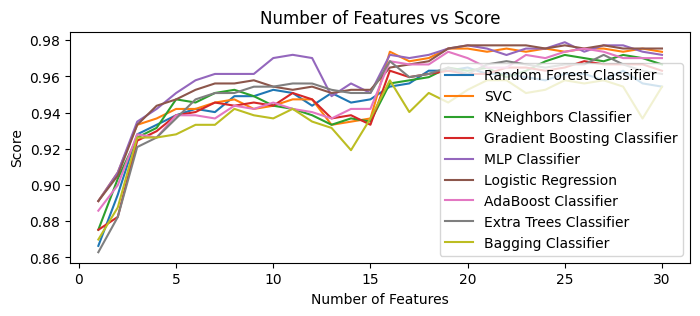

BaggingClassifier score: Index(['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness',
       'Concavity', 'Concave_points', 'Symmetry', 'Radius_SE', 'Perimeter_SE',
       'Area_SE', 'Compactness_SE', 'Concavity_SE', 'Concave_points_SE',
       'Radius_Worst', 'Texture_Worst', 'Perimeter_Worst', 'Area_Worst',
       'Smoothness_Worst', 'Compactness_Worst', 'Concavity_Worst',
       'Concave_points_Worst', 'Symmetry_Worst', 'Fractal_Dimension_Worst'],
      dtype='object')


In [94]:
# Using pipeline and SelectKBest to find the optimal amount of usable features.
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold

classifiers = [
    (RandomForestClassifier(), "Random Forest Classifier"),
    (SVC(), "SVC"),
    (KNeighborsClassifier(), "KNeighbors Classifier"),
    (GradientBoostingClassifier(), "Gradient Boosting Classifier"),
    (MLPClassifier(max_iter=1000), "MLP Classifier"),
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (AdaBoostClassifier(algorithm="SAMME"), "AdaBoost Classifier"),
    (ExtraTreesClassifier(), "Extra Trees Classifier"),
    (BaggingClassifier(), "Bagging Classifier")
]
plt.figure(figsize=(8, 5))

selected_features_dict = {}

for clf, clf_type in classifiers:
    features_scores = []
    for i in range(1,len(X.columns)+1):
        pipeline = Pipeline([
            ('selector', SelectKBest(score_func=f_classif, k=i)),
            ('classifier', clf)
        ])
        scores = cross_val_score(pipeline, X_scaled, y, cv=KFold(n_splits=10))
        mean_score = scores.mean()
        features_scores.append((i, mean_score))

    plt.plot([i[0] for i in features_scores], [i[1] for i in features_scores], label=clf_type)
    
    max_score = max(features_scores, key=lambda x: x[1])
    print(f'{clf_type} - Max score: {max_score[1]} with {max_score[0]} features')
    
    # Select the optimal number of features for this classifier
    selector = SelectKBest(score_func=f_classif, k=max_score[0])
    X_selected = selector.fit_transform(X_scaled, y)
    selected_features = X.columns[selector.get_support()]

    # Store the selected features in the dictionary
    selected_features_dict[clf_name] = selected_features


plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Number of Features vs Score')
plt.legend()
plt.show()

# Print the selected features for each classifier, ranked by score.
sorted_scores = sorted(selected_features_dict.items(), key=lambda x: x[1], reverse=True)
for clf_name, features in sorted_scores:
    print(f'{clf_name}: {features}')


I was originally using train_test_split() on ExtraTreesClassifier() but received different results on the graph each time, so I switched to cross_val_score() to be more thorough. With using train_test_split() I was often getting a max score at around 10 features, but using cross_val_score() the max score tends to be around 25 features. Out of a total of 30 features, I won't be losing many features to help the models run more efficiently. I then put this pipeline inside a for loop to iterate through each of my classifiers in my classifiers list. There is a trend across all of them to increase at around 17, and peak around 25.

NOTES TO SELF:
use these KBests to then tune hyperparameters. then maybe use those best hyperparameters on this section again? see if that improves the score? I could try it with 1 model atleast.


In [43]:
# 6. Model Training - I may have a version of this at step 2, so I can analyse the usefulness of steps 3-5.

#y = df['Diagnosis']
#X = df.drop('Diagnosis', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
scores = {}

# List of classifiers
classifiers = [
    (RandomForestClassifier(), "RandomForestClassifier score"),
    (RandomForestRegressor(), "RandomForestRegressor score"),
    (SVC(), "SVC score"),
    (KNeighborsClassifier(), "KNeighborsClassifier score"),
    (GradientBoostingClassifier(), "GradientBoostingClassifier score"),
    (MLPClassifier(), "MLPClassifier score"),
    (LogisticRegression(max_iter=1000), "LogisticRegression score"),
    (AdaBoostClassifier(algorithm="SAMME"), "AdaBoostClassifier score"),
    (ExtraTreesClassifier(), "ExtraTreesClassifier score"),
    (BaggingClassifier(), "BaggingClassifier score")
]

# Train and score each classifier
for clf, clf_name in classifiers:
    clf.fit(X_train, y_train)
    scores[clf_name] = clf.score(X_test, y_test)

# Print scores in descending order
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_scores:
    print(f'{key}: {value}')

SVC score: 0.9736842105263158
MLPClassifier score: 0.9736842105263158
LogisticRegression score: 0.9736842105263158
ExtraTreesClassifier score: 0.9736842105263158
RandomForestClassifier score: 0.9649122807017544
AdaBoostClassifier score: 0.9649122807017544
GradientBoostingClassifier score: 0.956140350877193
BaggingClassifier score: 0.956140350877193
KNeighborsClassifier score: 0.9473684210526315
RandomForestRegressor score: 0.865339600393056


/Users/user/Dropbox/Python/Wheel/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
# 8. Model Optimization
param1 = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search1 = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param1, cv=5, scoring='accuracy', n_iter=10)
random_search1.fit(X_train, y_train)
y_pred1 = random_search1.predict(X_test)
print(f'Best parameters for RandomForestClassifier using RandomizedSearchCV: {random_search1.best_params_}')
print(f'Best score for RandomForestClassifier using RandomizedSearchCV: {random_search1.best_score_}')

Best parameters for RandomForestClassifier using RandomizedSearchCV: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50}
Best score for RandomForestClassifier using RandomizedSearchCV: 0.9582417582417582


In [26]:
grid_search1 = GridSearchCV(RandomForestClassifier(), param_grid=param1, cv=5, scoring='accuracy')
grid_search1.fit(X_train, y_train)
y_pred1 = grid_search1.predict(X_test)
print(f'Best parameters for RandomForestClassifier using GridSearchCV: {grid_search1.best_params_}')
print(f'Best score for RandomForestClassifier using GridSearchCV: {grid_search1.best_score_}')

KeyboardInterrupt: 

Testing the difference in results between RandomizedSearchCV and GridSearchCV on the RandomForestClassifier.
RandomizedSearchCV took 28.5 seconds to run, and GridSearchCV took 11 minutes to run. 
GridSearchCV scored slightly higher, the difference in the best score is approximately 0.002.

In [ ]:
param_grid2 = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search2 = RandomizedSearchCV(ExtraTreesClassifier(), param_distributions=param_grid2, cv=5, scoring='accuracy', n_iter=10)
random_search2.fit(X_train, y_train)
y_pred2 = random_search2.predict(X_test)
print(f'Best parameters for ExtraTreesClassifier using RandomizedSearchCV: {random_search2.best_params_}')
print(f'Best score for ExtraTreesClassifier using RandomizedSearchCV: {random_search2.best_score_}')

Best parameters for ExtraTreesClassifier: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
Best score for ExtraTreesClassifier: 0.9670329670329672


In [ ]:
grid_search2 = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid2, cv=5, scoring='accuracy')
grid_search2.fit(X_train, y_train)
y_pred2 = grid_search2.predict(X_test)
print(f'Best parameters for ExtraTreesClassifier using GridSearchCV: {grid_search2.best_params_}')
print(f'Best score for ExtraTreesClassifier using GridSearchCV: {grid_search2.best_score_}')

Best parameters for ExtraTreesClassifier using GridSearchCV: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score for ExtraTreesClassifier using GridSearchCV: 0.9692307692307693


Testing the difference in results between RandomizedSearchCV and GridSearchCV on the ExtraTreesClassifier.
RandomizedSearchCV took 12.7 seconds to run, and GridSearchCV took 6 minutes to run. 
GridSearchCV scored slightly higher, the difference in the best score is also approximately 0.002.

In [ ]:
# checking all scores, but I want to avoid false negatives as much as possible, therefore Recall is the most important metric
accuracys = [recall_score, accuracy_score, precision_score, f1_score, roc_auc_score]

print("* Scores for RandomSearchCV - RandomForestClassifier*")
for accuracy in accuracys:
    print(accuracy.__name__, accuracy(y_test, y_pred1))
    
print("* Scores for RandomSearchCV - ExtraTreesClassifier*")
for accuracy in accuracys:
    print(accuracy.__name__, accuracy(y_test, y_pred2))

* Scores for RandomSearchCV - RandomForestClassifier*
recall_score 0.9302325581395349
accuracy_score 0.9649122807017544
precision_score 0.975609756097561
f1_score 0.9523809523809523
roc_auc_score 0.9580740255486406
* Scores for RandomSearchCV - ExtraTreesClassifier*
recall_score 0.9534883720930233
accuracy_score 0.9736842105263158
precision_score 0.9761904761904762
f1_score 0.9647058823529412
roc_auc_score 0.9697019325253848


In [ ]:
# Confusion matrix
print("Confusion matrix of RandomSearchCV RandomForestClassifier")
print(confusion_matrix(y_test, y_pred1))
print("Confusion matrix of RandomSearchCV ExtraTreesClassifier")
print(confusion_matrix(y_test, y_pred2))

Confusion matrix of RandomSearchCV RandomForestClassifier
[[70  1]
 [ 3 40]]
Confusion matrix of RandomSearchCV ExtraTreesClassifier
[[70  1]
 [ 2 41]]


In [ ]:
# Bagging with RandomForestClassifier
bag_clf = BaggingClassifier(
    RandomForestClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print("BaggingClassifier score: ", bag_clf.score(X_test, y_test))

# Boosting with AdaBoost
ada_clf = AdaBoostClassifier(
    RandomForestClassifier(), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5
)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print("AdaBoostClassifier score: ", ada_clf.score(X_test, y_test))


BaggingClassifier score:  0.9649122807017544
AdaBoostClassifier score:  0.9649122807017544
